In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
mushrooms = pd.read_csv('mushroom.csv')

### I. Test with an 'intuitive approach'

In [3]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp(-((np.linalg.norm(x-y))**2)/(2*(l**2)))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp(-((np.linalg.norm(x[i] - y))**2)/(2*(l**2)))
        return vect

In [4]:
#normalize the data
#class_shrooms = mushrooms['class']
mushrooms_copy = mushrooms.drop(['class'], axis=1)
#list_of_cols = mushrooms.columns
mushrooms_copy = StandardScaler().fit_transform(X=mushrooms)

In [5]:
#mushrooms = pd.DataFrame(mushrooms)
#mushrooms.columns = list_of_cols
#mushrooms['class'] = class_shrooms

In [6]:
#creation of unlabeled data
n_samples = mushrooms.shape[0]
mushrooms['label'] = np.ones(n_samples)*(-1)
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if mushrooms.loc[i,'class'] == 1 and random == 0:
        mushrooms.loc[i,'label'] = 1
    else:
        mushrooms.loc[i,'label'] = -1
mushrooms.groupby('label').count()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
label,,,,,,,,,
-1.0,46640,46640,46640,46640,46640,46640,46640,46640,46640
1.0,7395,7395,7395,7395,7395,7395,7395,7395,7395


In [7]:
n_cluster = 8
clusterized_data = KMeans(n_clusters=n_cluster, init='random').fit(mushrooms_copy)
mushrooms['cluster'] = clusterized_data.labels_
mushrooms[['class','label','cluster']].groupby('cluster').sum()

,class,label
cluster,,
0,2518,-3049.0
1,3920,-4762.0
2,0,-9934.0
3,922,-3326.0
4,6163,-5395.0
5,5435,-3322.0
6,4695,-5959.0
7,6022,-3498.0


In [8]:
list_of_ratio = []
for i in range(n_cluster):
    list_of_ratio.append(mushrooms[mushrooms['cluster'] == i]['label'].sum()/mushrooms[mushrooms['cluster'] == i]['class'].shape[0])
list_of_ratio = np.array(list_of_ratio)
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)
print('the cluster containing positive values is : ', positive_cluster, '\n', 
      'the one containing negative exampels is : ', negative_cluster)


the cluster containing positive values is :  7 
 the one containing negative exampels is :  2


In [9]:
reliable_positives = mushrooms[mushrooms['cluster'] == positive_cluster]
reliable_positives = reliable_positives[reliable_positives['label'] == 1]
reliable_negatives = mushrooms[mushrooms['cluster'] == negative_cluster]
reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]

In [10]:
print(reliable_positives.shape[0], reliable_negatives.shape[0])

1487 9934


In [11]:
reliable_negatives = reliable_negatives.sample(n=reliable_positives.shape[0])

In [12]:
#we suppose (it is true but for the test) that the ratio of correctly labeled example 
#is 1/2

In [13]:
#r = 3/8 with our procedure of unlabelisation

In [14]:
#df = df[['col3', 'col2', 'col1']]

In [15]:
gamma = 1
positives_array = reliable_positives.drop(['class','cluster'], axis=1)
negatives_array = reliable_negatives.drop(['class', 'cluster'], axis=1)
data_svm = np.vstack((positives_array,negatives_array))
n_reliable = data_svm.shape[0]
outcome = data_svm[:,8]
data_svm = data_svm[:,:8]
omega = np.empty((n_reliable,n_reliable))
for k in range(n_reliable):
    for i in range(n_reliable):
        omega[k,i] = outcome[k]*outcome[i]*rbf(x=data_svm[k,:],y=data_svm[i,:],l=10)
#now, computation of the rest of the matrix
first_row = np.hstack((0,-np.transpose(outcome)))
first_row = first_row.reshape(1,first_row.shape[0])
bot_of_mat_right = omega + (1/gamma)*np.eye(n_reliable)
bot_of_mat = np.hstack((outcome.reshape(n_reliable,1), bot_of_mat_right))
whole_mat = np.vstack((first_row, bot_of_mat))
right_hand = np.ones(n_reliable+1)
right_hand[0] = 0

In [16]:
coeffs = np.linalg.solve(a=whole_mat,b=right_hand)
b = coeffs[0]
alpha = coeffs[1:coeffs.shape[0]]

In [17]:
test_data = mushrooms.drop(['class','label','cluster'], axis=1).to_numpy()
results = np.empty(n_samples)
for i in tqdm(range(n_samples)):
    results[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=test_data[i,:],l=10))

100%|██████████| 54035/54035 [08:11<00:00, 109.99it/s]


In [37]:
sorted_results = np.sort(results)

In [38]:
good_ratio = int(n_samples/2)

In [39]:
b = sorted_results[good_ratio]

In [40]:
last_results = np.empty(n_samples)
for i in range(n_samples):
    last_results[i] = np.sign(results[i] - b)

In [41]:
np.sum(last_results)

0.0

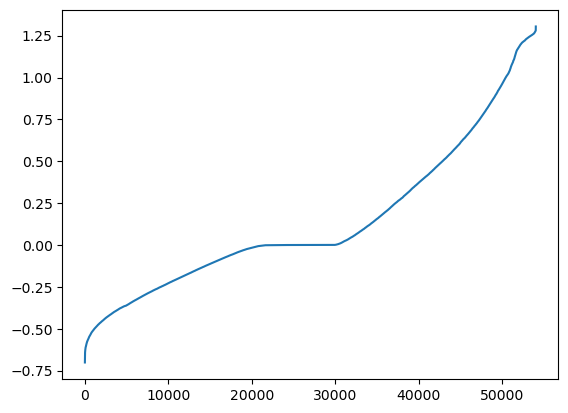

In [48]:
plt.plot(sorted_results)

In [50]:
last_results

array([1., 1., 1., ..., 1., 1., 1.])

In [52]:
np.unique(last_results)

array([-1.,  0.,  1.])